<a href="https://colab.research.google.com/github/usintec/3DBEFUnet/blob/master/3DBEFUnet_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# =========================
# Setup Kaggle & Download BraTS2020 Dataset
# =========================

# Install required libraries
!pip install -q nibabel pydicom nilearn matplotlib opencv-python kaggle

import os
import zipfile
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import glob


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 88.5 MB/s eta 0:00:00


In [2]:

# =========================
# 1. Kaggle API Setup
# =========================
# Upload kaggle.json from your Kaggle account to Colab
from google.colab import files

print("Please upload your kaggle.json (from Kaggle > Account > Create API Token)")
files.upload()

# Move kaggle.json to ~/.kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# =========================
# 2. Download BraTS2020 Dataset
# =========================
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation -p /content/

# Unzip dataset
!unzip -q /content/brats20-dataset-training-validation.zip -d /content/brats2020



Please upload your kaggle.json (from Kaggle > Account > Create API Token)


Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
100% 4.16G/4.16G [02:06<00:00, 15.3MB/s]
100% 4.16G/4.16G [02:06<00:00, 35.2MB/s]


In [4]:
# Check dataset structure
!ls /content/brats2020

# =========================
# 3. Load & Explore MRI Data
# =========================
# Example: Load one subject
example_path = glob.glob("/content/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/*.nii*")[0]
print("Example file:", example_path)

# Load NIfTI image using nibabel
img = nib.load(example_path)
img_data = img.get_fdata()

print("Image shape:", img_data.shape)  # typically (240, 240, 155)



BraTS2020_TrainingData	BraTS2020_ValidationData
Example file: /content/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii
Image shape: (240, 240, 155)


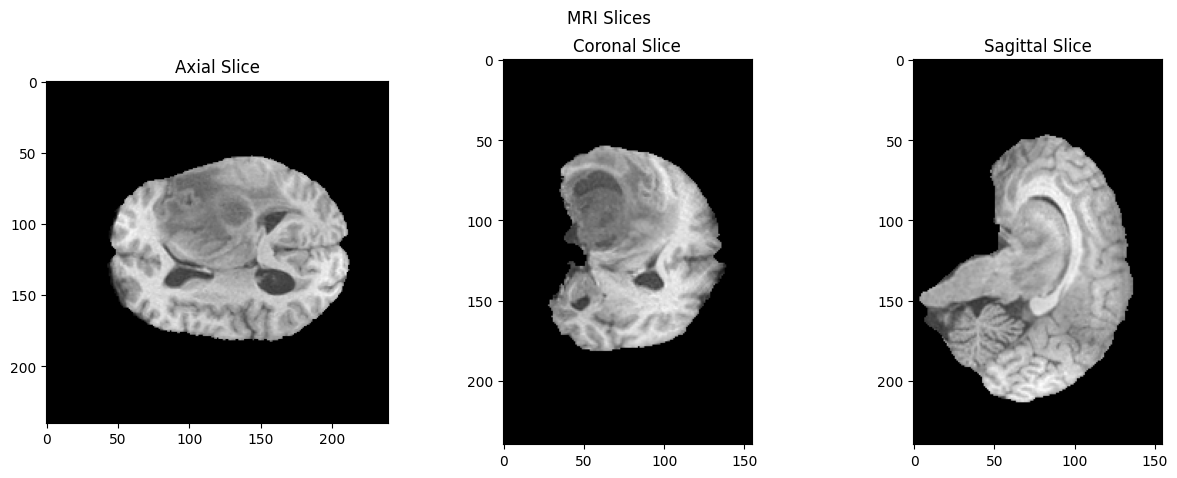

In [5]:
# =========================
# 4. Visualize MRI slices
# =========================
def plot_slices(img_data, title="MRI Slices"):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img_data[:, :, img_data.shape[2]//2], cmap="gray")
    axes[0].set_title("Axial Slice")
    axes[1].imshow(img_data[:, img_data.shape[1]//2, :], cmap="gray")
    axes[1].set_title("Coronal Slice")
    axes[2].imshow(img_data[img_data.shape[0]//2, :, :], cmap="gray")
    axes[2].set_title("Sagittal Slice")
    plt.suptitle(title)
    plt.show()

plot_slices(img_data)



In [20]:
# =========================
# 5. Data Loader Preparation (for BEFUnet)
# =========================
from torch.utils.data import Dataset, DataLoader
import torch

import os, glob
import numpy as np
import nibabel as nib
import torch
from torch.utils.data import Dataset

class BraTSDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir (str): Path to BraTS2020 training folder
                            e.g. /content/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData
            transform (callable, optional): Optional transform to be applied
                                            on a sample (modalities, seg).
        """
        # Collect all case directories
        self.case_dirs = sorted(glob.glob(os.path.join(data_dir, "BraTS20_Training_*")))
        self.transform = transform

        print(f"Found {len(self.case_dirs)} cases in {data_dir}")

    def __len__(self):
        return len(self.case_dirs)

    def __getitem__(self, idx):
      case_dir = self.case_dirs[idx]
      # match .nii and .nii.gz, with full prefix in name
      files = sorted(glob.glob(os.path.join(case_dir, "*.nii*")))

      assert len(files) == 5, f"Expected 5 files in {case_dir}, found {len(files)}"

      # Load modalities
      modalities = []
      for f in files:
          if "seg" not in f:
              img = nib.load(f).get_fdata()
              modalities.append(img)
      modalities = np.stack(modalities, axis=0)  # (4, H, W, D)

      # Load segmentation
      seg_file = [f for f in files if "seg" in f][0]
      seg = nib.load(seg_file).get_fdata()

      # Convert to torch tensor
      modalities = torch.tensor(modalities, dtype=torch.float32)
      seg = torch.tensor(seg, dtype=torch.long)

      if self.transform:
          modalities, seg = self.transform(modalities, seg)

      return modalities, seg



In [21]:

# =========================
# 6. Create DataLoader
# =========================
train_dataset = BraTSDataset("/content/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData")
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Test one batch
imgs, mask = next(iter(train_loader))
print("Batch MRI shape:", imgs.shape)  # [B, 4, H, W, D]
print("Batch Mask shape:", mask.shape)


Found 369 cases in /content/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData
Batch MRI shape: torch.Size([1, 4, 240, 240, 155])
Batch Mask shape: torch.Size([1, 240, 240, 155])
